## Mount Drive

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install torch
!pip3 install torchvision
!pip3 install opencv-python

In [0]:
import numpy as np
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa, circle
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random
from math import sqrt

import torch
from PIL import Image

fine_net_path = '/content/drive/My Drive/csc420/unet_circle_fine.model'
saved_net_path = '/content/drive/My Drive/csc420/unet_circle.model'

## Customed Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms 

# Define customized dataset
class CircleDataset(Dataset):
    def __init__(self, img_list, mask_list, transform=None):
        self.imgs = []
        self.masks = []
        self.transform = transform
        
        # add corresponding image and labels
        for i in range(len(img_list)):
            self.imgs.append(Image.fromarray(img_list[i], 'L'))
            self.masks.append(Image.fromarray(mask_list[i], 'L'))                               

    def __getitem__(self, index):
        img = self.imgs[index]
        circle = self.masks[index]
        if self.transform is not None:
            img = self.transform(img)
            circle = self.transform(circle)
        return img, circle

    def __len__(self):
        return len(self.imgs)

## Define Model

In [6]:
from torch import nn, optim
import torch.nn.functional as F

def double_conv(in_channel, out_channel):
  return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU())

def up_sample(in_channel, out_channel):
  return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, 2, stride=2, padding=0),
            nn.ReLU())

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.down_layer1 = double_conv(1, 32)
        self.down_layer2 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(32, 64)
        )
        self.down_layer3 = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(64, 128)
        )
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(128, 256)
        )
        self.up_sample1 = up_sample(256, 128)
        self.up_sample2 = up_sample(128, 64)
        self.up_sample3 = up_sample(64, 32)
        self.up_layer1 = double_conv(256, 128)
        self.up_layer2 = double_conv(128, 64)
        self.up_layer3 = nn.Sequential(
            double_conv(64, 32),
            nn.Conv2d(32, 1, kernel_size=1, padding=0)
        )
    def forward(self, img):
        # Contracting/downsampling path
        down_1 = self.down_layer1(img)
        down_2 = self.down_layer2(down_1)
        down_3 = self.down_layer3(down_2)   

        bottleneck = self.bottleneck(down_3)
        bottleneck_upsample = self.up_sample1(bottleneck)
        bottleneck_upsample = torch.cat((bottleneck_upsample, down_3), dim=1)
        
        # Expanding/upsampling path
        up_1 = self.up_layer1(bottleneck_upsample)
        up_1_upsample = self.up_sample2(up_1)
        up_1_upsample = torch.cat((up_1_upsample, down_2), dim=1)
        
        up_2 = self.up_layer2(up_1_upsample)
        up_2_upsample = self.up_sample3(up_2)
        up_2_upsample = torch.cat((up_2_upsample, down_1), dim=1)
        
        out = self.up_layer3(up_2_upsample)
        out = nn.Sigmoid()(out)
        return out

# build a u-net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Net().to(device)

from torchsummary import summary
summary(model, (1, 200, 200))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             320
       BatchNorm2d-2         [-1, 32, 200, 200]              64
              ReLU-3         [-1, 32, 200, 200]               0
            Conv2d-4         [-1, 32, 200, 200]           9,248
       BatchNorm2d-5         [-1, 32, 200, 200]              64
              ReLU-6         [-1, 32, 200, 200]               0
         MaxPool2d-7         [-1, 32, 100, 100]               0
            Conv2d-8         [-1, 64, 100, 100]          18,496
       BatchNorm2d-9         [-1, 64, 100, 100]             128
             ReLU-10         [-1, 64, 100, 100]               0
           Conv2d-11         [-1, 64, 100, 100]          36,928
      BatchNorm2d-12         [-1, 64, 100, 100]             128
             ReLU-13         [-1, 64, 100, 100]               0
        MaxPool2d-14           [-1

## Define Loss Function and Train Function

In [0]:
def mse_loss(predicts, targets):
    predicts = predicts.reshape(-1)
    targets = targets.reshape(-1)
    # intersection = torch.dot(predicts, targets)
    loss = torch.mean(((predicts - targets)**2))
    return loss

def dice_loss(predicts, targets):
    smooth = 1.
    predicts = predicts.reshape(-1)
    targets = targets.reshape(-1)
    intersection = torch.dot(predicts, targets)

    score = (2. * intersection + smooth) / (predicts.sum() + targets.sum() + smooth)
    return 1. - score

# def iou_loss(predicts, targets):
#     smooth = 0.00001
#     m_predicts = (predicts).reshape(-1)
#     m_targets = (targets).reshape(-1)
#     intersection = (predicts * targets).float().sum()
#     union = (predicts + targets).float().sum()
#     iou = (intersection + smooth) / (union + smooth)
#     return 1. - iou

def train_net_with_eval(model, 
                         trainloader, 
                         testloader, 
                         train_criterion, 
                         test_criterion, 
                         device,
                         model_path='/content/drive/My Drive/csc420/unet_circle.model',
                         epochs=5):
    print("Start Training ...")
    print("trianloader length:{}".format(len(trainloader)))
    print("testloader length:{}".format(len(testloader)))
    print("saved model path:{}".format(model_path))
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)  
    model.train()

    min_eval_loss = np.inf
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()
            inputs, masks = data
            inputs = inputs.to(device)
            masks = masks.to(device)

            outputs = model(inputs)
            loss = train_criterion(outputs, masks)
            # backward and optimize for training
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_losses.append(running_loss/len(trainloader))
        else:
            # Evaluate model after every epoch
            with torch.no_grad():
                test_loss = 0
                for i, data in enumerate(testloader, 0):
                    test_inputs, test_masks = data
                    test_inputs = test_inputs.to(device)
                    test_masks = test_masks.to(device)

                    # predict and caculate loss
                    eval_predicts = model(test_inputs)
                    eval_loss = test_criterion(eval_predicts, test_masks)
                    
                    test_loss += eval_loss.item()
                
                test_loss = test_loss/len(testloader)
                test_losses.append(test_loss)

                # save model with smallest valuation loss
                if test_loss < min_eval_loss:
                    print("Epoch{}: Save best model with test loss: {:.3f}.. ".format(e+1 , test_loss))
                    min_eval_loss = test_loss
                    torch.save(model.state_dict(), model_path)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss))

    print("List of train loss:{}".format(train_losses))
    print("List of test loss:{}".format(test_losses))


## Helper Functions

In [0]:
def draw_circle(img, row, col, rad):
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def noisy_circle(size, radius, noise):
    img = np.zeros((size, size), dtype=np.float)

    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)

    # Noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img

def draw_mask(params):
    img = np.zeros((200, 200), dtype=np.float)
    x, y, r = params
    rr, cc = circle(x, y, r)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = 1
    img = (img * 255).astype(np.uint8)
    return img

def generate_dataset(size, noise):
    data_set = []
    mask_set = []
    # mask all images back to 0 ~ 255
    for i in range(size):
        circle, img = noisy_circle(200, 50, noise)
        img = ((img / img.max()) * 255).astype(np.uint8)
        data_set.append(img)
        mask_set.append(draw_mask(circle))
    return data_set, mask_set

def find_circle(model, img):
    # Convert input image into a tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    test_img = ((img / img.max()) * 255).astype(np.uint8)
    test_img = Image.fromarray(test_img, 'L')
    test_img = img_transform(test_img).view(1, 1, 200, 200).to(device)

    # Read net weight, train first!
    trained_model = model
    # trained_model.load_state_dict(torch.load(saved_net_path, map_location='cpu'))

    predict = trained_model(test_img)
    # print(predict.shape)
    # predicted_masks = (predict>0.0001).int() * 255
    predicted_masks = ((predict> 0.5) * 255).int()
    pil_mask = transforms.ToPILImage()(predicted_masks[0].cpu())
    np_mask = np.array(pil_mask)

    circle = find_circle_params(np_mask)
    return circle
  
# Function to find the circle on  
# which the given three points lie  
# Mostly from: # https://www.geeksforgeeks.org/equation-of-circle-when-three-points-on-the-circle-are-given/
def find_circle_with_points(x1, y1, x2, y2, x3, y3): 
    x12 = float(x1 - x2)
    x13 = float(x1 - x3) 
    y12 = float(y1 - y2) 
    y13 = float(y1 - y3) 
    y31 = float(y3 - y1)
    y21 = float(y2 - y1)
    x31 = float(x3 - x1)
    x21 = float(x2 - x1) 
  
    # x1^2 - x3^2  
    sx13 = pow(x1, 2) - pow(x3, 2)  
    sy13 = pow(y1, 2) - pow(y3, 2)  
  
    sx21 = pow(x2, 2) - pow(x1, 2)  
    sy21 = pow(y2, 2) - pow(y1, 2)  
  
    f = (((sx13) * (x12) + (sy13) * 
          (x12) + (sx21) * (x13) + 
          (sy21) * (x13)) // (2 * 
          ((y31) * (x12) - (y21) * (x13)) + np.finfo(np.float32).eps))          
    g = (((sx13) * (y12) + (sy13) * (y12) + 
          (sx21) * (y13) + (sy21) * (y13)) // 
          (2 * ((x31) * (y12) - (x21) * (y13)) + np.finfo(np.float32).eps))  
    c = (-pow(x1, 2) - pow(y1, 2) - 2 * g * x1 - 2 * f * y1)

    h = -int(g)
    k = -int(f) 
    sqr_of_r = h * h + k * k - c
  
    # r is the radius  
    r = int(round(sqrt(sqr_of_r), 5))  
    # print("find_circle_with_points: {}, {}, {}", h, k, r)
    return h, k, r

def verify_circle(circle, a, b):
    x, y, r = circle
    d = sqrt(float(x-a)**2 + float(y-b)**2)
    return True, d if abs(d-r) < 1 else False, d

def find_circle_params(mask):
    laplacian = cv.Laplacian(mask.astype(float), cv.CV_64F)
    points = np.where(laplacian != 0)
    points = tuple(zip(*points))

    params = (0, 0, 0)
    # Find center and radius that most points agree on
    agree = False
    iterations = 0
    max_iter = 15
    most_inliers = 0
    most_inliers_params = (0, 0, 0)
    # Main loop
    while not agree and iterations < max_iter:
        iterations += 1
  
        # Find three points randomly
        x1 = 0; y1 = 0; x2 = 0; y2 = 0; x3 = 0; y3 = 0
        while True:
            i = random.randint(0, len(points)-1)
            x1, y1 = points[i]
            if not( x1 is 0 or y1 is 0 or x1 is 199 or y1 is 199): break
        while True:
            i = random.randint(0, len(points)-1)
            x2, y2 = points[i]
            if not( x2 is 0 or y2 is 0 or x2 is 199 or y2 is 199): break
        while True:
            i = random.randint(0, len(points)-1)
            x3, y3 = points[i]
            if not( x3 is 0 or y3 is 0 or x3 is 199 or y3 is 199): break
        
        # Compute circle parameters
        circle = find_circle_with_points(x1, y1, x2, y2, x3, y3)
        x, y, r = circle
        # print(x, y, r)

        # If find invalid parameters find another one
        if x < 0 or y < 0 or x > 200 or y > 200 or r > 50:
            iterations -= 1
        else:
            count = 0 # Count inliers
            threshold = int(len(points) * 0.95)
            # If 90% points on the circle agree on computed center and radius, return it
            bad_points = 0 # Points on border
            for i in range(len(points)):
                  x, y = points[i]
                  if x is 0 or y is 0 or x is 199 or y is 199: bad_points += 1
                  elif verify_circle(circle, x, y): count += 1
            
            # print("inliers: {}".format(count + bad_points))
            if count + bad_points >= threshold:
                agree = True
                params = circle
            else:
                  if count + bad_points > most_inliers:
                      most_inliers = count + bad_points
                      most_inliers_params = circle
                  # Last interation return params with most inliers
                  if iterations is max_iter - 1:
                      agree = True
                      params = most_inliers_params
    
    return params

def iou(params0, params1):
    row0, col0, rad0 = params0
    row1, col1, rad1 = params1

    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)

    return (
        shape0.intersection(shape1).area /
        shape0.union(shape1).area
    )

## Train A Model

In [0]:
train_size = 10000
test_size = 3000
train_img, train_mask = generate_dataset(train_size, 2)
test_img, test_mask = generate_dataset(test_size, 2)

img_transform = transforms.Compose([
      transforms.ToTensor()
])

train_dataset = CircleDataset(train_img, train_mask, transform=img_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)
inputs, labels = next(iter(train_loader))
print(len(train_loader))
print(inputs.shape, labels.shape)
test_dataset = CircleDataset(test_img, test_mask, transform=img_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True, num_workers=0)
inputs, labels = next(iter(test_loader))
print(len(test_loader))
print(inputs.shape, labels.shape)

# build a net
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# train net with given input and labels and with MSE as loss function
print("Train unet with MSE as loss function...")
train_net_with_eval(model,
                    train_loader,
                    test_loader, 
                    mse_loss, 
                    mse_loss,
                    device,
                    model_path=saved_net_path,
                    epochs=5)

# params, img = noisy_circle(200, 50, 2)
# print(params)
# find_circle(img)

500
torch.Size([20, 1, 200, 200]) torch.Size([20, 1, 200, 200])
150
torch.Size([20, 1, 200, 200]) torch.Size([20, 1, 200, 200])
Train unet with MSE as loss function...
Start Training ...
trianloader length:500
testloader length:150
saved model path:/content/drive/My Drive/csc420/unet_circle.model
Epoch1: Save best model with test loss: 0.514.. 
Epoch: 1/5..  Training Loss: 0.654..  Test Loss: 0.514.. 
Epoch2: Save best model with test loss: 0.506.. 
Epoch: 2/5..  Training Loss: 0.508..  Test Loss: 0.506.. 
Epoch3: Save best model with test loss: 0.504.. 
Epoch: 3/5..  Training Loss: 0.505..  Test Loss: 0.504.. 
Epoch: 4/5..  Training Loss: 0.504..  Test Loss: 0.504.. 
Epoch5: Save best model with test loss: 0.503.. 
Epoch: 5/5..  Training Loss: 0.504..  Test Loss: 0.503.. 
List of train loss:[0.0018879860639572144, 0.003760704874992371, 0.005606562852859497, 0.00747066330909729, 0.009320271730422974, 0.01117377507686615, 0.013017100095748902, 0.014831772923469544, 0.016695648312568666,

## Load Trained Model: Modlfy path to model here to load weight for different model

In [8]:
# fine_net_path: model trained with mse loss (unet_circle_fine.model)

trained_model = Net().to(device)
trained_model.load_state_dict(torch.load(saved_net_path, map_location='cpu'))

<All keys matched successfully>

## Testing by IOU

In [9]:
results = []
for _ in range(1000):
    params, img = noisy_circle(200, 50, 2)
    detected = find_circle(trained_model, img)
    # print(params, detected)
    results.append(iou(params, detected))
results = np.array(results)
print((results > 0.7).mean())

0.678


## Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iou: 0.942042


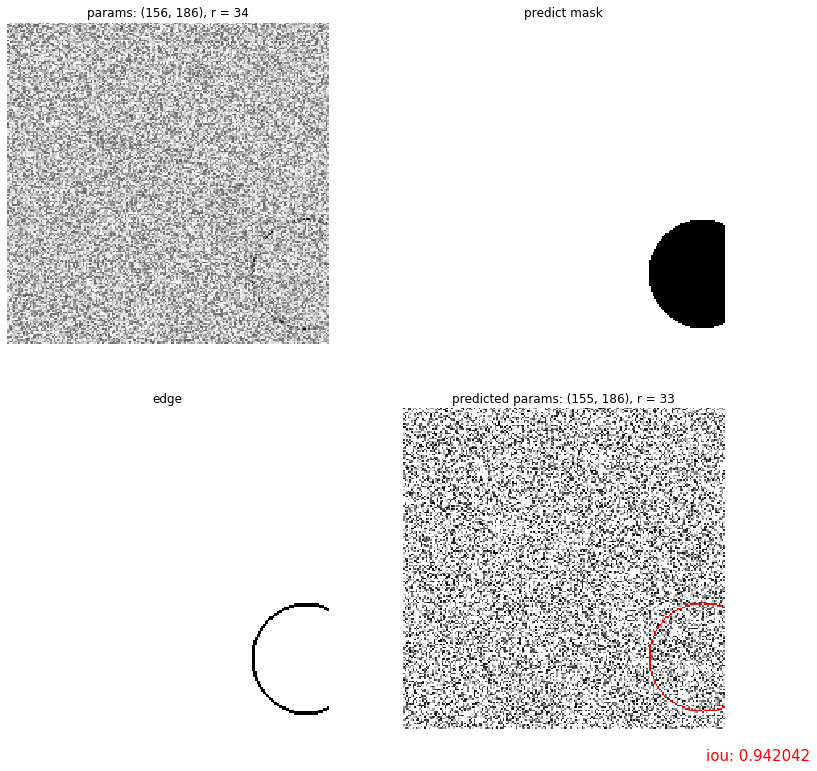

In [0]:
def show_predicted_image():
    params, img = noisy_circle(200, 50, 2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_transform = transforms.Compose([
      transforms.ToTensor()
    ])

    # Find predict mask predicted by model
    test_img = ((img / img.max()) * 255).astype(np.uint8)
    test_img = Image.fromarray(test_img, 'L')
    test_img = img_transform(test_img).view(1, 1, 200, 200).to(device)
    predict = model(test_img)
    predicted_masks = ((predict>0.5) * 255).int()
    pil_mask = transforms.ToPILImage()(predicted_masks[0].cpu())
    np_mask = np.array(pil_mask)

    # Find edges
    laplacian = cv.Laplacian(np_mask.astype(float), cv.CV_64F)
    edge = (laplacian != 0).astype(int)


    x, y, r = params
    predict_params = find_circle_params(np_mask)
    x_p, y_p, r_p = predict_params
    iou_score = iou(params, predict_params)
    print('iou: {:4f}'.format(iou_score))

    predict_img = np.zeros((img.shape[0], img.shape[1], 3)).astype(float)
    predict_img[:,:,0] = img
    predict_img[:,:,1] = img
    predict_img[:,:,2] = img

    cv.circle(predict_img, (y_p, x_p), r, (255, 0, 0))
    # ax.text(3, 2, 'iou:{}'.format(iou))

    fig, axs = plt.subplots(2, 2, figsize=(13,13))
    axs[0,0].axis('off')
    axs[0,0].set_title('params: ({}, {}), r = {}'.format(x, y, r))
    axs[0,0].imshow(img, cmap="Greys")
    axs[0,0].set_aspect('equal')

    axs[1,1].axis('off')
    axs[1,1].set_title('predicted params: ({}, {}), r = {}'.format(x_p, y_p, r_p))
    axs[1,1].imshow(predict_img, cmap="Greys")
    axs[1,1].text(x_p+r_p, y_p+r_p, 'iou: {:4f}'.format(iou_score), fontsize=15, color='red')
    axs[1,1].set_aspect('equal')

    axs[0,1].axis('off')
    axs[0,1].set_title('predict mask')
    axs[0,1].imshow(np_mask, cmap="Greys")
    axs[0,1].set_aspect('equal')

    axs[1,0].axis('off')
    axs[1,0].set_title('edge')
    axs[1,0].imshow(edge, cmap="Greys")
    axs[1,0].set_aspect('equal')


    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

show_predicted_image()